# Data acquisiton

In [1]:
import pylef   # importar pylef 
import visa    # importar a bilioteca pyVISA para lidar com virtualização de instrumentos
import matplotlib.pyplot as plt  # importar a bilioteca pyplot para fazer gráficos
import numpy as np   # importar a biblioteca Numpy para lidar com matrizes
import time          # importar a bilioteca para funções temporais
import pandas as pd   # importa bilioteca pandas para  lidar com processamento de dados
import os
# próxima linha faz plotar o gráfico dentro do notebook
# %matplotlib inline   

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/visa.py:23: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  FutureWarning,


In [2]:
def screenshot(filename):
    #setting up hardcopy
#     scope.instr.timeout = 20000 # set timeout to 10 seconds
    strings = ['SAVE:IMAGE:FILEFORMAT BMP',
               'HARDCOPY:BUTTON PRINTS',
              'HARDCopy:PORT']
    for string in strings:
        scope.write(string)
        scope.wait()
    #screen shot
    scope.instr.write('HARDCOPY START')
    values = scope.instr.read_raw() 
    scope.wait()
    newFile = open(filename+'.bmp', 'wb')
    newFileByteArray = bytearray(values)
    newFile.write(newFileByteArray)
    newFile.close()
    return filename+'.bmp'+ ' saved!'

## Connect to instruments

In [3]:
# imprime os recursos para ter certeza que os instrumentos estão conectados
visa.ResourceManager().list_resources()

('ASRL1::INSTR', 'ASRL2::INSTR')

In [4]:
func_gen = pylef.BK4052()          # definição do gerador de funções
scope = pylef.TektronixTBS1062()   # definição do osciloscópio

ValueError: O osciloscopio BK scope nao foi identificado:
Verique se o equipamento está ligado e se o cabo USB 
foi conectado. Se o problema persistir, 
desconecte o cabo USB, aguarde 20 segundos 
e conecte novamente.

## Screenshot  e trace saving

In [13]:
fname = 'diode_resistor_junction_capacitance' #filename

In [14]:
screenshot(fname) #save screenshot

'diode_resistor_junction_capacitance.bmp saved!'

In [15]:
scope.save_channels(fname,sep=',')  

... file => 2021_04_06/diode_resistor_junction_capacitance_17_49_25 saved !!


(array([-1.640e-05, -1.636e-05, -1.632e-05, ...,  8.348e-05,  8.352e-05,
         8.356e-05]),
 array([0.0496, 0.0496, 0.0496, ..., 0.0496, 0.0496, 0.0496]),
 array([0.0012, 0.0016, 0.0012, ..., 0.0012, 0.0012, 0.0012]))

## Sweep DC level

In [109]:
##### Pré-aquisição
# mude a onda para uma senóide! O que acontece se usarmos a onda triângular?
func_gen.ch1.set_function('sine')
## ajuste o trigger externo
# func_gen.ch1.sync_on()   # ligar o sync reference ao canal 1
# scope.trigger.set_source('ext')  # ajusta o trigger para externo no osciloscópio
## ajusta média nos canais
scope.set_average_number(64)  # ajusta o número de médias
scope.set_average()    # turn average ON
#scope.set_sample()       # turn average OFF
## parametros de varredura
PATH = 'diode_ac_resistance_100mV_300ohms'  # pasta onde salvar todos os arquivos
freq0 = 60#
Vpp = 0.05   # Tensão pico-a-pico na saida do gerador
vdc0,vdc1, npt = -0.5, 2, 20  # frequências inicial, final e número de pontos
## parâmetros inicias do gerador
func_gen.ch1.set_frequency(freq0) 
func_gen.ch1.set_Vpp(Vpp)
func_gen.ch1.set_offset(vdc0)
func_gen.ch1.set_phase(0.0)
## tenha certeza que o gerador está ligado e que o canal 1 está na escala certa
func_gen.ch1.turn_on()   # liga o canal 1
scope.set_horizontal_scale((1/freq0)/4.)  # escala horizontal = 1/4 período (2.5 oscilações em tela)
scope.ch1.set_smart_scale()  # rescala o canal 1
scope.ch2.set_smart_scale()  # rescala o canal 2
try:
    os.mkdir(PATH)
finally:
    print('path ok')

path ok


FileExistsError: [Errno 17] File exists: 'diode_ac_resistance_100mV_300ohms'

## DC level of ch2

In [104]:
#### Aquisição de dados!! ####
vdc = np.linspace(vdc0, vdc1, npt, endpoint = True)  # varredura logaritmica
Vpp1, Vpp2 = [], []    # listas para guardar as variáveis
### aquisição de dados no gerador com varredura de frequência
for m, vdcP in enumerate(list(vdc)):  # loop de aquisição
    ### ajuste dos instrumentos
    func_gen.ch1.set_offset(vdcP)   # muda a frequência
    time.sleep(0.05)   # espere 50 microssegundos
    scope.ch2.set_smart_scale()    #  rescala o canal 2
    time.sleep(1)
    ### aquisição de dados
    Vpp1.append(scope.ch1.measure.Vpp()) # acumula a medida do Vpp no canal 1
      # wait between the data acquisition
    Vpp2.append(scope.ch2.measure.mean())  # acumula a medida do Vpp no canal 2
    ### salva em arquivo os dados da aquisição
#     file_sweep_name = 'sweep_freq_{:03g}_{:2.2f}_Hz'.format(m,freqP).replace('.','p')  # nome dos arquivos de sweep
    file_sweep_name = 'sweep_vdc_{:03g}'.format(m)  # nome dos arquivos de sweep
    #-----
#     screenshot(os.path.join(PATH,'traços-temporal-imagens',file_sweep_name))
#     scope.save_channels(file_sweep_name, PATH = PATH)    
#     plt.show()      # impressão na tela!
Vpp1 = np.array(Vpp1)  # convete a lista em array
Vpp2 = np.array(Vpp2)  # convete a lista em array
#------
## Análise de dados (não mude a variável PATH)
dados = pd.DataFrame()   # inicializa um dataframe do pandas
dados['vdc (V)']= vdc
dados['Vpp1 (V)'], dados['Vmean2 (V)'] = Vpp1, Vpp2
dados.to_csv(os.path.join(PATH,'dados_sweep_vdc_res_dc.csv'))

## Vpp1,Vpp2 versus vdc

In [111]:
#### Aquisição de dados!! ####
vdc = np.linspace(vdc0, vdc1, npt, endpoint = True)  # varredura logaritmica
Vpp1, Vpp2 = [], []    # listas para guardar as variáveis
### aquisição de dados no gerador com varredura de frequência
for m, vdcP in enumerate(list(vdc)):  # loop de aquisição
    ### ajuste dos instrumentos
    func_gen.ch1.set_offset(vdcP)   # muda a frequência
    time.sleep(0.05)   # espere 50 microssegundos
    scope.ch2.set_smart_scale()    #  rescala o canal 2
    time.sleep(1)
    ### aquisição de dados
    Vpp1.append(scope.ch1.measure.Vpp()) # acumula a medida do Vpp no canal 1
      # wait between the data acquisition
    Vpp2.append(scope.ch2.measure.Vpp())  # acumula a medida do Vpp no canal 2
    ### salva em arquivo os dados da aquisição
#     file_sweep_name = 'sweep_freq_{:03g}_{:2.2f}_Hz'.format(m,freqP).replace('.','p')  # nome dos arquivos de sweep
    file_sweep_name = 'sweep_vdc_{:03g}'.format(m)  # nome dos arquivos de sweep
    #-----
#     screenshot(os.path.join(PATH,'traços-temporal-imagens',file_sweep_name))
#     scope.save_channels(file_sweep_name, PATH = PATH)    
#     plt.show()      # impressão na tela!
Vpp1 = np.array(Vpp1)  # convete a lista em array
Vpp2 = np.array(Vpp2)  # convete a lista em array
#------
## Análise de dados (não mude a variável PATH)
dados = pd.DataFrame()   # inicializa um dataframe do pandas
dados['vdc (V)']= vdc
dados['Vpp1 (V)'], dados['Vpp2 (V)'] = Vpp1, Vpp2
dados.to_csv(os.path.join(PATH,'dados_sweep_vdc_res.csv'))

In [69]:
data = pd.read_csv('diode_ac_resistance_100mV/dados_sweep_vdc_swap.csv')
Vpp_all1 = data['Vpp1 (V)']
Vpp_diode = data['Vpp2 (V)']
vdc = data['vdc (V)']

In [110]:
data = pd.read_csv('diode_ac_resistance_100mV_300ohms/dados_sweep_vdc_res_dc.csv')
Vpp_all2 = data['Vpp1 (V)']
Vpp_res = data['Vpp2 (V)']
vdc = data['vdc (V)']

KeyError: 'Vpp2 (V)'

In [83]:
Vpp_all2

0     0.054760
1     0.054760
2     0.056371
3     0.053794
4     0.053472
        ...   
95    0.054760
96    0.052506
97    0.052828
98    0.052828
99    0.052506
Name: Vpp1 (V), Length: 100, dtype: float64

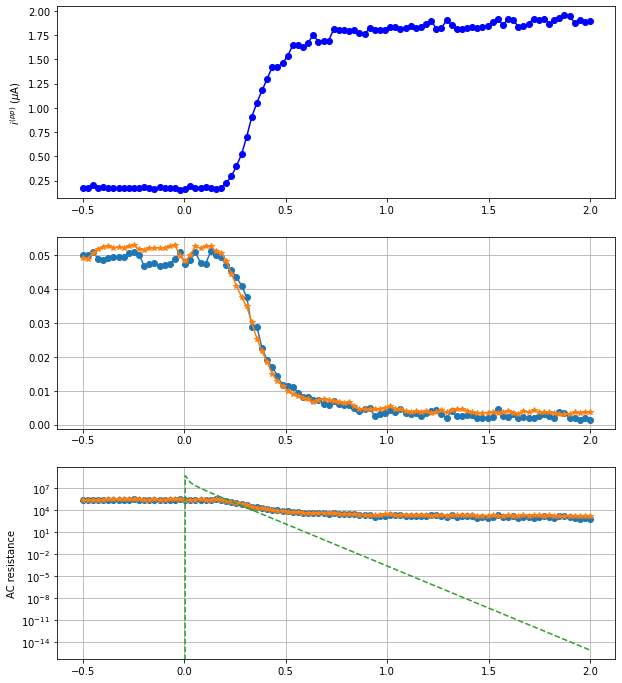

In [90]:
# plota o diagrama de bode para a transmissão e exporta em png
fig,ax = plt.subplots(3,1,figsize=(10,12))   # define uma figura
ipp = Vpp_res/27e3
vdiode = Vpp_diode
vdiode2 = Vpp_all2-Vpp_res 

rdiode = vdiode/ipp
rdiode2 = vdiode2/ipp
ax0=ax[0]
ax0.plot(vdc,ipp*1e6, 'bo-')   # plota a transmissão  
ax0.set_ylabel('$i^{(pp)}$ ($\mu$A)')   # seta escala do eixo y
#------------------
ax0=ax[1]
ax0.plot(vdc,vdiode2, 'o-')   # plota a transmissão  
ax0.plot(vdc,vdiode, '*-')   # plota a transmissão  


ax0.grid()
#------------
β=39.6
n=1.5
Is=0.5*1e3*1e-12
Id = Is*(np.exp(β*vdc/n)-1) # corrente no diodo
ax0=ax[2]
ax0.semilogy(vdc,rdiode2, 'o-')   # plota a transmissão 
ax0.semilogy(vdc,rdiode, '*-')   # plota a transmissão   
ax0.plot(vdc,n/β/Id, '--')   # plota a transmissão  
ax0.set_ylabel('AC resistance')   # seta escala do eixo y
ax0.grid()
#segundo eixo
# fig.savefig(PATH + 'bode_diag.pdf', bbox_inches = 'tight')  # salva figura na pasta de trabalho

plt.show()

In [85]:
Vt=25.6e-3
id0=1.57/27e3
Vt/id0

440.2547770700637

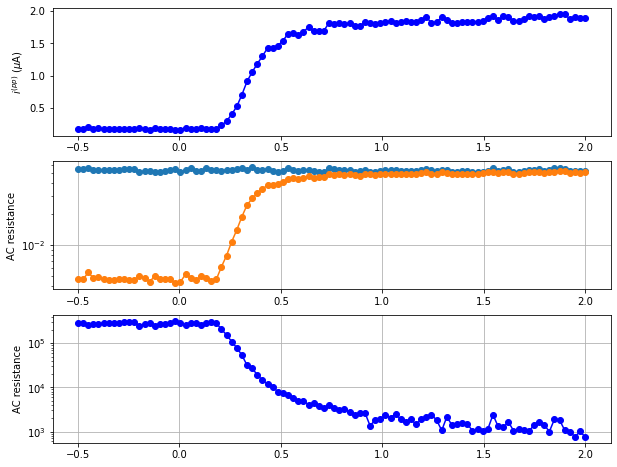

In [62]:
# plota o diagrama de bode para a transmissão e exporta em png
fig,ax = plt.subplots(3,1,figsize=(10,8))   # define uma figura
ipp = Vpp_res/27e3
vdiode = Vpp_diode
# vdiode2 = Vpp_all-Vpp2

rdiode = vdiode/ipp
ax0=ax[0]
ax0.plot(vdc,ipp*1e6, 'bo-')   # plota a transmissão  
ax0.set_ylabel('$i^{(pp)}$ ($\mu$A)')   # seta escala do eixo y
#------------------
ax0=ax[1]
ax0.semilogy(vdc,Vpp1, 'o-')   # plota a transmissão  

ax0.semilogy(vdc,Vpp2, 'o-')   # plota a transmissão  
ax0.set_ylabel('AC resistance')   # seta escala do eixo y

ax0.grid()
#------------------
ax0=ax[2]
ax0.semilogy(vdc,rdiode, 'bo-')   # plota a transmissão  
ax0.set_ylabel('AC resistance')   # seta escala do eixo y
ax0.grid()
#segundo eixo
# fig.savefig(PATH + 'bode_diag.pdf', bbox_inches = 'tight')  # salva figura na pasta de trabalho

plt.show()

Diode capacitance

In [21]:
##### Pré-aquisição
# mude a onda para uma senóide! O que acontece se usarmos a onda triângular?
func_gen.ch1.set_function('sine')
## ajuste o trigger externo
# func_gen.ch1.sync_on()   # ligar o sync reference ao canal 1
# scope.trigger.set_source('ext')  # ajusta o trigger para externo no osciloscópio
## ajusta média nos canais
scope.set_average_number(128)  # ajusta o número de médias
scope.set_average()    # turn average ON
#scope.set_sample()       # turn average OFF
## parametros de varredura
PATH = 'diode_ac_resistance_100mV/'  # pasta onde salvar todos os arquivos
Vpp = 0.1   # Tensão pico-a-pico na saida do gerador
vdc = -3
freq0, freq1, Nfreq = 5e3, 1e6, 10  # frequências inicial, final e número de pontos
## parâmetros inicias do gerador
func_gen.ch1.set_frequency(freq0) 
func_gen.ch1.set_Vpp(Vpp)
func_gen.ch1.set_offset(vdc)
func_gen.ch1.set_phase(0.0)
## tenha certeza que o gerador está ligado e que o canal 1 está na escala certa
func_gen.ch1.turn_on()   # liga o canal 1
scope.set_horizontal_scale((1/freq0)/4.)  # escala horizontal = 1/4 período (2.5 oscilações em tela)
scope.ch1.set_smart_scale()  # rescala o canal 1
scope.ch2.set_smart_scale()  # rescala o canal 2

In [22]:
#### Aquisição de dados!! ####
freq = np.logspace(np.log10(freq0), np.log10(freq1), Nfreq, endpoint = True)  # varredura logaritmica
Vpp1, Vpp2 = [], []    # listas para guardar as variáveis
phase1, phase2 = [], []    # listas para guardar as variáveis
### aquisição de dados no gerador com varredura de frequência
for m, freqP in enumerate(list(freq)):  # loop de aquisição
    ### ajuste dos instrumentos
    func_gen.ch1.set_frequency(freqP)   # muda a frequência
    periodP = 1./freqP   # período da onda
    num = np.floor(-np.log10(periodP)/3.) + 1 # referência para a escala do gráfico
    scope.set_horizontal_scale(periodP/4.)  # escala horizontal = 1/4 período (2.5 oscilações em tela)
    time.sleep(0.05)   # espere 50 microssegundos
    scope.ch2.set_smart_scale()    #  rescala o canal 2
    ### aquisição de dados
    Vpp1.append(scope.ch1.measure.Vpp()) # acumula a medida do Vpp no canal 1
    phase1.append(scope.ch1.measure.phase()) # acumula a medida da fase no canal 1    
    time.sleep(0.05)  # wait between the data acquisition
    Vpp2.append(scope.ch2.measure.Vpp())  # acumula a medida do Vpp no canal 2
    phase2.append(scope.ch2.measure.phase()) # acumula a medida da fase no canal 2
    ### salva em arquivo os dados da aquisição
#     file_sweep_name = 'sweep_freq_{:03g}_{:2.2f}_Hz'.format(m,freqP).replace('.','p')  # nome dos arquivos de sweep
    file_sweep_name = 'sweep_freq_{:03g}'.format(m)  # nome dos arquivos de sweep
    #-----
#     screenshot(os.path.join(PATH,'traços-temporal-imagens',file_sweep_name))
#     scope.save_channels(file_sweep_name, PATH = PATH)    
    plt.show()      # impressão na tela!
Vpp1 = np.array(Vpp1)  # convete a lista em array
Vpp2 = np.array(Vpp2)  # convete a lista em array
phase1 = np.array(phase1)  # convete a lista em array
phase2 = np.array(phase2)  # convete a lista em arra

FileNotFoundError: [Errno 2] No such file or directory: 'exemplo-pylef/passa-baixas/bode_diag.pdf'

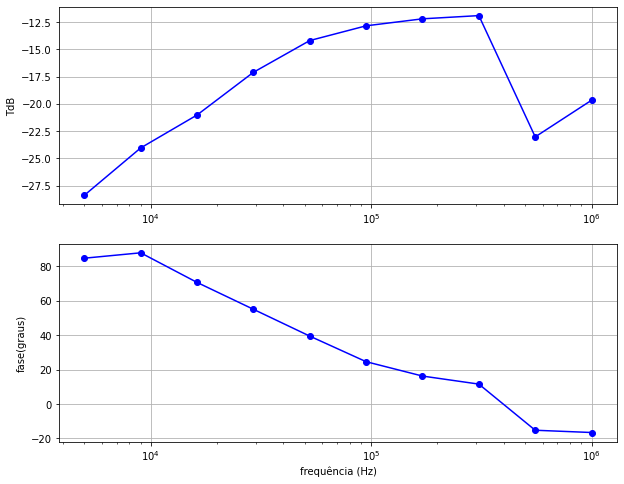

In [23]:
## Análise de dados (não mude a variável PATH)
T = Vpp2/Vpp1   # cálculo da transmissão 
T_dB = 20*np.log10(T)  # transmissão em dB
dados = pd.DataFrame()   # inicializa um dataframe do pandas
dados['frequencia (Hz)']= freq
dados['Vpp1 (V)'], dados['Vpp2 (V)'] = Vpp1, Vpp2
dados['fase (rad)'] = -phase1

# plota o diagrama de bode para a transmissão e exporta em png
fig,ax = plt.subplots(2,1,figsize=(10,8))   # define uma figura
ax0=ax[0]
ax0.plot(freq,T_dB, 'bo-')   # plota a transmissão  
ax0.set_xscale('log')   # seta a escala de x para logaritmica
ax0.grid()
ax0.set_ylabel('TdB')   # seta escala do eixo y
#segundo eixo
ax0=ax[1]
ax0.plot(freq,-phase1, 'bo-')   # plota a transmissão  
ax0.set_xscale('log')   # seta a escala de x para logaritmica
# Por que não usamos escala log no eixo y também?
ax0.set_xlabel('frequência (Hz)')   # seta escala do eixo x

ax0.set_ylabel('fase(graus)')   # seta escala do eixo y
ax0.grid()
fig.savefig(PATH + 'bode_diag.pdf', bbox_inches = 'tight')  # salva figura na pasta de trabalho
dados.to_csv(PATH + 'dados_sweep_freq.csv')
plt.show()